In [1]:
import sys
sys.path.append('../')  

from data.dummy_datasets import *
from utils.operations import E2G
from models.gnca import GNCAModel
from utils.plots import *
from utils.operations import *
import torch
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
from tqdm import tqdm
import matplotlib.animation as animation
import math
from utils.sample_pool import SamplePool
import os

In [2]:
EPOCHS = 8000
POOL_SIZE = 1024
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8  # number of states batched at each pool sample call
USE_PATTERN_POOL =  True
FORWARD_ITER_RANGE = (8, 32)
EXTRA_CHANNELS = 8

In [3]:
length = 7

coords, E = create_cubic_canvas(length, 1)
G = E2G(E, int(math.pow(length, 3)))
adj = nx.adjacency_matrix(G).toarray()

seed = np.zeros(coords.shape[0])
seed[coords.shape[0] // 2] = 1

for i in range(EXTRA_CHANNELS):
    seed_ = np.zeros(coords.shape[0])
    seed = np.column_stack((seed, seed_))

_target = create_pyramid_mask(length)

adj = torch.tensor(adj, dtype=torch.float32).to(DEVICE)
seed = torch.tensor(seed, dtype=torch.float32).to(DEVICE)
target = torch.tensor(_target, dtype=torch.float32).to(DEVICE)

if USE_PATTERN_POOL:
    target = target.unsqueeze(0).expand(BATCH_SIZE, -1)

In [4]:
gnca = GNCAModel(input_dim=(EXTRA_CHANNELS+1)*2, channel_n=EXTRA_CHANNELS+1, fire_rate=0.5, device=DEVICE)
optimizerG = optim.Adam(gnca.parameters(), lr=2e-4)
pool = SamplePool(x=seed.repeat(POOL_SIZE, 1, 1))
# torch.nn.utils.clip_grad_norm_(gnca.parameters(), max_norm=1.0) # gradient clipping

<Axes3D: title={'center': 'target'}>

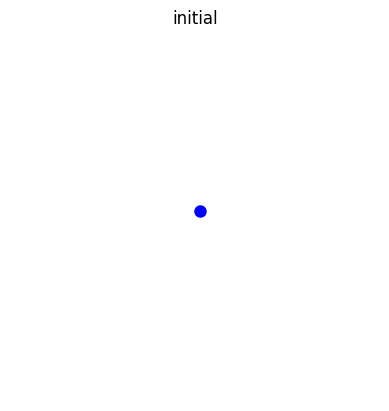

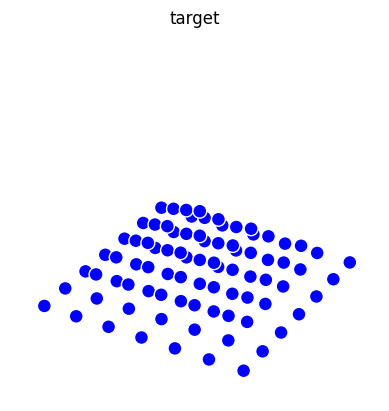

In [5]:
plot_3d_G(G, coords, "initial", transparent=True, show_edges=False, angle=30, node_alpha=seed[:, 0].to('cpu').detach().numpy(), fixed_range=True, axis_range=1)
plot_3d_G(G, coords, "target", transparent=True, show_edges=False, angle=30, node_alpha=_target, fixed_range=True, axis_range=1)

Training

In [6]:
# removing previous log files
if os.path.exists('train_log'):
    for filename in os.listdir('train_log'):
        file_path = os.path.join('train_log', filename)
        os.unlink(file_path)  

In [7]:
losses = []

gnca.train()

def loss_f(yhat, y):
    return F.mse_loss(yhat, y)

def train_step(x):
    iter_n = np.random.randint(FORWARD_ITER_RANGE[0], FORWARD_ITER_RANGE[1])
    for i in range(iter_n):
        x = gnca(x, adj)  
    loss = loss_f(x[:, :, 0], target)
    optimizerG.zero_grad()
    loss.backward()
    optimizerG.step()

    x = x.detach()
    
    return x, loss

# training loop
with tqdm(total=EPOCHS, desc="Training Progress") as pbar:
    for epoch in range(EPOCHS):
        
        if USE_PATTERN_POOL:
            batch = pool.sample(BATCH_SIZE)
            x0 = batch.x
            loss_rank = torch.tensor([loss_f(x0[i, :, 0], target[i, :]).item() for i in range(BATCH_SIZE)])
            loss_rank = loss_rank.argsort(descending=True)
            x0 = x0[loss_rank]
            x0[:1] = seed
        else:
            x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    
        x, loss = train_step(x0)
        
        adj = adj.detach()

        if USE_PATTERN_POOL:
            batch.x[:] = x
            batch.commit()

        losses.append(loss.item())

        # # gradient clipping
        # for param in gnca.parameters():
        #     if param.grad is not None:
        #         param.grad.data /= (torch.norm(param.grad.data) + 1e-8)

        if (epoch % 100 == 0):
            generate_pool_image(coords, pool, epoch)

        # Update progress bar description
        pbar.set_postfix({'Loss': loss.item()})
        pbar.update(1)  # Move progress bar forward

Training Progress: 100%|██████████| 8000/8000 [09:51<00:00, 13.53it/s, Loss=0.18]   


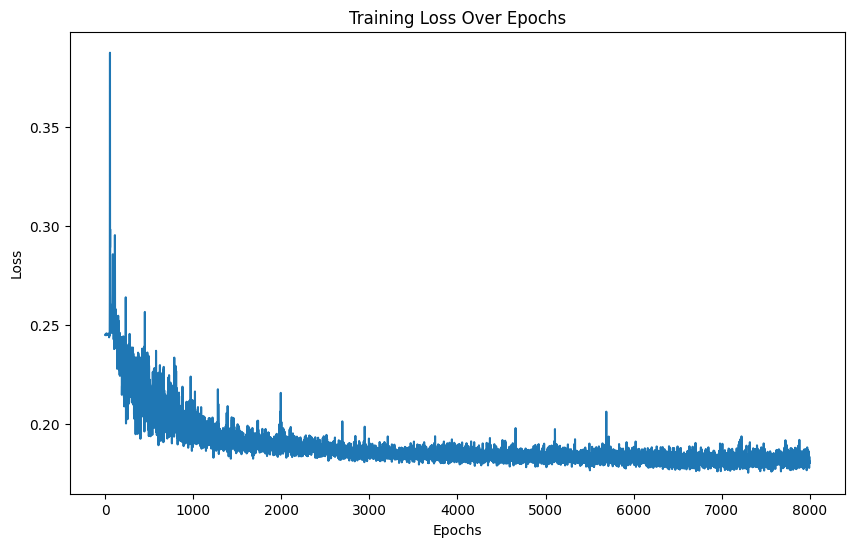

In [8]:
plot_loss(losses, EPOCHS)

<Axes3D: title={'center': 'last'}>

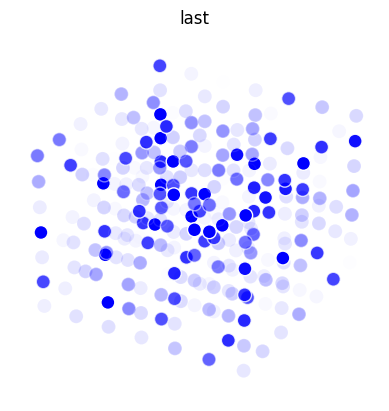

In [11]:
alphas = []

seed = np.zeros(coords.shape[0])
seed[coords.shape[0] // 2] = 1

for i in range(EXTRA_CHANNELS):
    seed_ = np.zeros(coords.shape[0])
    seed = np.column_stack((seed, seed_))

seed = torch.tensor(seed, dtype=torch.float32).to(DEVICE)
seed = seed.unsqueeze(0)

gnca.zero_grad()

alphas.append(seed[0, :, 0].cpu().detach().numpy())

for i in range(1000):
    seed = gnca(seed, adj)
    alphas.append(seed[0, :, 0].cpu().detach().numpy())

plot_3d_G(G, coords, "last", transparent=True, show_edges=False, angle=30, node_alpha=alphas[-1], fixed_range=True, axis_range=1)
    

In [1]:
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111, projection='3d')

# update function for the animation
def update(i):
    ax.clear()
    if np.any(alphas[i] > 0):
        plot_3d_G(G, coords, "life", transparent=True, show_edges=False, angle=30, node_alpha=alphas[i], ax=ax, fixed_range=True, axis_range=1)
        ax.set_title(f"Epoch: {i * 1}")
        return ax
    else:
        ani.event_source.stop()

ani = animation.FuncAnimation(fig, update, frames=len(alphas), interval=100, repeat=False)

ani.save('life.gif', dpi=300, writer=animation.PillowWriter(fps=20))

NameError: name 'plt' is not defined